In [278]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [279]:
auxiliares_path = os.path.abspath(os.path.join('..'))
if auxiliares_path not in sys.path:
    sys.path.append(auxiliares_path+'\\auxiliares')

#Importando funciones auxiliares    
import auxiliares.helpers as hp
import auxiliares.preproc_nyc_sqf as preproc

# 1. Ingesta de data y análisis de esta

In [280]:
df_2009 = pd.read_csv("datasets/2009_1perc.csv").drop('Unnamed: 0', axis=1)
df_2010 = pd.read_csv("datasets/2010_1perc.csv").drop('Unnamed: 0', axis=1)

In [281]:
df_2009.head(3)

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2009,41,1779,4032009,130,A,O,P,1.0,CPW,...,,41,G,7,,1013067,0238633,CM,1,20
1,2009,108,5805,10292009,1050,A,O,P,3.0,BURG,...,,108,J,,,1012043,0212157,CM,1,14
2,2009,43,8340,10062009,1450,1,O,P,1.0,MISD,...,,43,E,,,1017599,0240200,CM,1,20


In [282]:
df_2010.head(3)

,year,pct,ser_num,datestop,timestop,recstat,inout,trhsloc,perobs,crimsusp,...,zip,addrpct,sector,beat,post,xcoord,ycoord,dettypcm,linecm,detailcm
0,2010,6,487,1192010,1420,1,O,P,2,FEL,...,,6,G,,38,983543,208767,CM,1,85
1,2010,42,7138,9042010,225,1,I,T,10,FELONY,...,,42,E,,,1014172,241737,CM,1,45
2,2010,33,2628,6302010,1240,1,I,T,5,ROBBERY,...,,33,B,6,,1000916,245710,CM,1,85


In [283]:
print(f'datos 2009: {df_2009.shape[1]} columnas y {df_2009.shape[0]} datos')
print(f'datos 2010: {df_2010.shape[1]} columnas y {df_2010.shape[0]} datos')


datos 2009: 111 columnas y 5812 datos
datos 2010: 111 columnas y 6013 datos


Los datos de ambos DataFrames tienen 111 columnas, que lo más probable que no todas sean de utilidad, además algunas columnas como 'beat' o 'post' tienen registros con datos faltantes, en formato de espacios. Veremos más a profundidad estos datos faltantes.

In [284]:
df_2009_nan = df_2009.replace(' ', np.nan)
df_2010_nan = df_2010.replace(' ', np.nan)

In [285]:
df_2009_nan.isna().sum().sort_values(ascending=False)[:23]

aptnum      5812
othfeatr    5812
rescode     5812
premtype    5812
zip         5812
state       5812
officrid    5727
arstoffn    5464
sumoffen    5456
post        5268
offverb     4559
offshld     4205
beat        3622
addrnum     3300
stname      3225
premname     591
trhsloc      205
xcoord       168
ycoord       168
sector       116
stinter       40
crossst       40
cs_other       0
dtype: int64

Como podemos ver en la lista de arriba, se aprecia que hay 22 columnas con valores perdidos, pero lo interesante es en cuanto a la cantidad de datos perdidos, se puede apreciar que desde "aptnum" a "stname" pasan de 5.812 a 3.225 datos perdidos respectivamente, despues baja drásticamente a 591 con "premname" y siguen siendo menos los datos perdidos.

Lo interesante es que estos datos perdidos hay que tratarlos, pero contamos con una función auxiliar que hace este trabajo, de imputar valores en algunas columnas, según algunos criterios ahí definidos, además de reglas como por ejemplo que la edad de la persona esté entre 18 y 100 años, de modo que si viola esta regla, le asigna valos np.nan, eliminando estos registros posteriormente (No deberían poder controlar gente menor de edad y si tiene más de 100 años es muy probable que sea un error de tipeo).

In [286]:
df_consolidado = pd.concat([df_2009.set_index(df_2009['year']), 
                            df_2010.set_index(df_2010['year'])])

In [287]:
df_procesado, a, b = preproc.create_suitable_dataframe(df_consolidado)

['perobs']


In [288]:
#Guardamos el archivo ya procesado en un CSV.
df_procesado.to_csv('stop_and_frisk.csv')

# 2. Análisis Exploratorio

## 2.1. Comportamiento de Vector objetivo 'arstmade'.

In [289]:
df_procesado['arstmade'].value_counts('%')*100

N    93.712032
Y     6.287968
Name: arstmade, dtype: float64

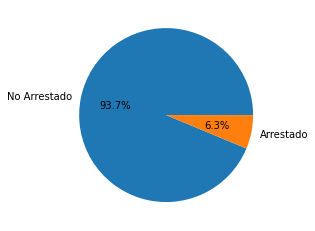

In [290]:
fig, ax = plt.subplots()
labels = ['No Arrestado', 'Arrestado']
sizes = [df_procesado['arstmade'].value_counts('%')[0]*100, df_procesado['arstmade'].value_counts('%')[1]*100]
ax.pie(sizes, labels = labels, autopct='%1.1f%%');
plt.show()

De todas las personas controladas aproximadamente un 6.3% fueron arrestadas

***¿De qué ciudad provienenestos registros?***

Text(0.5, 0.98, 'Arresto según controles por ciudad')

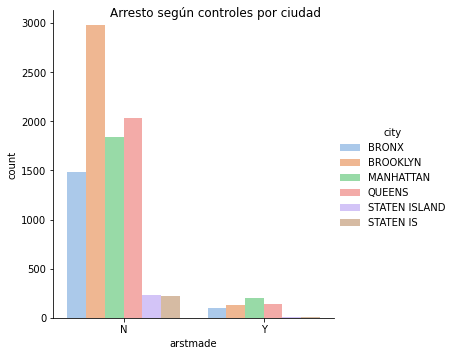

In [291]:
g = sns.catplot(data = df_procesado, x = 'arstmade', hue = 'city', kind = 'count', palette = 'pastel')
g.fig.suptitle('Arresto según controles por ciudad')

In [292]:
df_procesado.groupby('city')['arstmade'].value_counts()

city           arstmade
BRONX          N           1480
               Y            100
BROOKLYN       N           2979
               Y            132
MANHATTAN      N           1844
               Y            197
QUEENS         N           2038
               Y            142
STATEN IS      N            217
               Y              9
STATEN ISLAND  N            235
               Y             10
Name: arstmade, dtype: int64

De los controles realizados por ciudad, se puede obtener la siguiente información:
* La mayor cantidad de controles se realizaron en ***Brooklyn y Queens*** y la ciudad que menos controles tuvo, fue ***Staten Island***.
* Hay un country llamado ***STATEN IS***, que es lo mismo que *STATEN ISLAND*, por lo cual hay que corregirlo.

***¿Qué podemos decir en cuanto a la raza y el sexo de las personas que fueron controladas?***

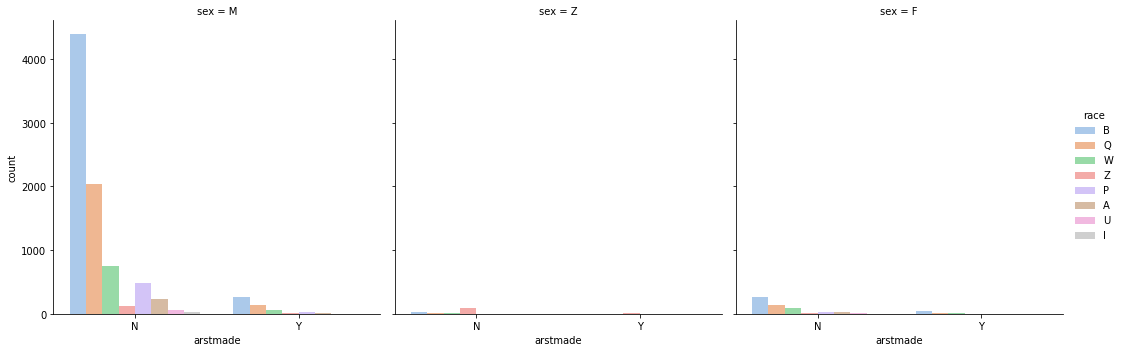

In [293]:
sns.catplot(data = df_procesado, x='arstmade', hue='race', col='sex', kind='count', palette='pastel')

* Del total de personas que son **controladas**, la mayoría son de raza ***Negra*** e ***Hispanos blancos***, seguidas de ***Hispanos negros***, ya muy por debajo se encuentras todas las demás razas, resaltando también aunque minoritaria, el control a ***Blancos*** e ***Hispanos negros***.
* Pasando ahora a los que son **arrestados**, nos encontramos con el mismo panorama, se detienen principalmente a personas de raza ***Negra*** e ***Hispanos blancos***.

Ya con estos antecedentes, podemos ver una clara tendencia de que los datos recopilados están sesgados de una forma racista, no se controla a la gente por igual, tienen una clara tendencia a controlar a personas negras e hispanas, por lo que probablemente los resultados de los modelos que puedan salir de analizar esta información, sean también sesgado. Por lo que tendremos que tener mucho cuidado en la ética del análisis que realizemos.

# 3. Feature Engieneering

In [298]:
for i in df_procesado.columns:
    if df_procesado[i].unique().shape[0] < 2:
        print(i, df_procesado[i].unique().shape[0])

addrtyp 1
dettypcm 1


In [299]:
df_procesado['linecm'].unique()

array([1, '1'], dtype=object)

In [312]:
df_procesado.drop(columns = ['addrtyp', 'dettypcm', 'linecm'], axis=1, inplace=True)

Eliminamos las siguientes variables, por tener sólo un tipo de dato y no brindar información:
* ***addrtyp***
* ***dettypcm*** 
* ***linecm***

***¿Cuales atributos tienen más de 2 valores únicos?***

In [313]:
for i in df_procesado.columns:
    if df_procesado[i].unique().shape[0] > 2:
        print(i, df_procesado[i].unique().shape[0])

trhsloc 4
typeofid 4
sex 3
race 8
haircolr 11
eyecolor 11
build 5
city 6
sector 18
beat 63
month 12
meters 30


In [311]:
df_procesado.city.value_counts()

BROOKLYN         3111
QUEENS           2180
MANHATTAN        2041
BRONX            1580
STATEN ISLAND     245
STATEN IS         226
Name: city, dtype: int64

Modificamos el valor de ***STATEN IS***, para que sea ***STATEN ISLAND***

In [315]:
df_procesado['city'].replace(to_replace='STATEN IS', value='STATEN ISLAND', inplace=True)

In [305]:
df_procesado['beat'].value_counts('%')*100

U       63.103485
9        3.495684
1        2.749654
7        2.579132
4        2.344666
          ...    
30       0.010658
  25     0.010658
26       0.010658
  61     0.010658
  42     0.010658
Name: beat, Length: 63, dtype: float64

In [316]:
df_procesado.drop(columns=['beat'], axis=1, inplace=True)

Eliminamos  ***beat*** por tener 63 valores diferentes y un 63% de ellos son valores desconocidos, por lo que no aporta información relevante.

***¿Qué sucede con las columnas que comienzan con "pf_"?***

Sucede que todas esas columnas hacen alusión a un tipo de detención usando fuerza física por parte del oficial, por lo cual los uniremos en una categoría llamada ***violent_arrest***, en donde si un detención tiene presente al menos uno de estos factores, será catalogado como violento.

De esta manera podremos eliminar todas estas columnas, para dejar presente sólo la detención violenta.

In [317]:
df_procesado["violent_arrest"] = np.select([df_procesado["pf_hands"] == "Y", df_procesado["pf_wall"] == "Y", df_procesado["pf_grnd"]  == "Y", 
                                          df_procesado["pf_drwep"] == "Y" , df_procesado["pf_ptwep"] == "Y" , df_procesado["pf_baton"] == "Y",
                                          df_procesado["pf_hcuff"] == "Y" , df_procesado["pf_pepsp"] == "Y", df_procesado["pf_other"] == "Y"],
                                          [1, 1, 1, 1, 1, 1, 1, 1, 1], 0)

In [318]:
df_procesado.drop(columns = ["pf_hands", "pf_wall", "pf_grnd", "pf_drwep",
                            "pf_ptwep", "pf_baton", "pf_hcuff", "pf_pepsp",
                            "pf_other"], inplace = True)

0    76.084408
1    23.915592
Name: violent_arrest, dtype: float64

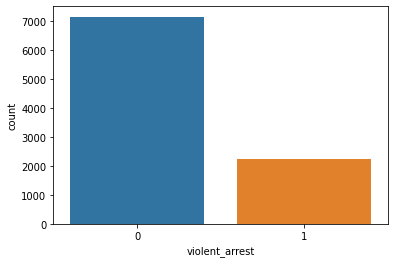

In [324]:
sns.countplot(data=df_procesado, x='violent_arrest')
df_procesado['violent_arrest'].value_counts('%')*100

Del total de controles realizados, un 23.9% de ellos fueron realizados por el oficial utilizando fuerza física.

En otras palabras 1 de cada 4 controles fueron realizados de forma violenta por los oficiales.

## 3.1. Binarización de datos

Debido a que los modelos de machine learning no funcionan con valores categóricos, es necesario recodificarlos de alguna manera, para que estos puedan quedar en formato numérico, ahora utilizaré la función de la librería *pandas* 'get_dummies' la que convierte las variables categóricas en variables dummies en donde toman el valor de 1 si cumplen la condición de la columna y 0 si no.

In [325]:
var_categoricas = []
for i in df_procesado:
    if df_procesado[i].dtype == object:
        var_categoricas.append(i)

In [326]:
df_binarizado = hp.binarizar(df_procesado, var_categoricas)

In [328]:
df_binarizado.head(5)

,month,meters,violent_arrest,recstat_1,inout_I,trhsloc_H,trhsloc_T,trhsloc_U,typeofid_O,typeofid_R,...,sector_I,sector_J,sector_K,sector_M,sector_N,sector_P,sector_Q,sector_R,sector_T,sector_U
year,,,,,,,,,,,,,,,,,,,,,
2009,4,1.798320,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,10,1.920240,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,12,1.676400,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2009,5,1.767840,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009,11,1.557528,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## 3.2. Separación de datos.

Los datos del año 2009 serán utilizados para el entrenamiento y los del año 2010 lo usaremos para para validación.

Nuestros vectores objetivos serán dos:
* ***arstmade_Y***: Si el control terminó en un arresto.
* ***violent_arrest***: Si el control fué violento (el oficial utilizó fuerza física).

In [329]:
# Entrenamiento
df_train = df_binarizado.query("year==2009")
X_train_arstmade = df_train.drop(columns = ["arstmade_Y"])
y_train_arstmade = df_train["arstmade_Y"]

X_train_violent = df_train.drop(columns = ["violent_arrest"])
y_train_violent = df_train["violent_arrest"]

# Testeo
df_test = df_binarizado.query("year==2010")
X_test_arstmade = df_test.drop(columns = ["arstmade_Y"])
y_test_arstmade = df_test["arstmade_Y"]

X_test_violent = df_test.drop(columns = ["violent_arrest"])
y_test_violent = df_test["violent_arrest"]

In [331]:
df_test.columns.difference(df_train.columns)

Index([], dtype='object')

No hay diferencias entre los datos de entrenamiento y testeo, por lo cual ya estamos listos para comenzar a modelar.